# Más de clasificadores

Vamos a ver algunos aspectos prácticos de la implementación de modelos de clasificación, que nos permitirán mejorar su desempeño y tiempo de entrenamiento.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original", sep='\s+', header=None, na_values=['?'],
                 names=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name'])
df.set_index('car_name', inplace=True)
df.dropna(inplace=True)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
car_name,,,,,,,,
chevrolet chevelle malibu,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0
buick skylark 320,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0
plymouth satellite,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0
amc rebel sst,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0
ford torino,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0


In [ ]:
df['origin_country'] = df['origin']==1
df.origin_country = df.origin_country.map({True: 'USA', False: 'Other'})
df.origin_country.value_counts()

,count
origin_country,
USA,245
Other,147


In [ ]:
# Extraccion de matrices de caracteristicas y objetivo, y division de los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split
X = df[['mpg', 'acceleration']]
y = df['origin_country']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, train_size=0.8)
print(f'Tamaño del conjunto de entrenamiento es: {X_train.shape}')
print(f'Tamaño del conjunto de prueba es: {X_test.shape}')

Tamaño del conjunto de entrenamiento es: (313, 2)
Tamaño del conjunto de prueba es: (79, 2)


# Sobre los métodos de sintonización de hiperparámetros

El método de sintonización de hipérparámetros que implementa **GridSearchCV** es la búsqueda exhaustiva en cuadrícula, esto es, probar uno por uno todas los valores que se le entregan de los hiperparámetros. Así, sí tuviéramos que sintonizar 3 hiperparámetros, y del primero quisiéramos probar 10 valores, del segundo 50, y del tercero, **GridSearchCV** probaría $10*50*3 = 1500$ combinaciones posibles de hiperparámetros, cada uno por validación cruzada con el núemro de folds que se configure. Por ejemplo, si se usarán 5 folds, el modelo a sintonizar se entrenaría 5 veces por cada combinación de hiperparámetros, así que en este caso, el modelo se entrenaría $1500*5 = 7500$ veces. Esto evidentemente puede tomar mucho tiempo, sobretodo si nuestra matriz de características es grande.

Por todo lo anterior, han surgido métodos alternativos de sintonización de hiperparámetros.

In [ ]:
import time
start_time = time.time()

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)

grid = {'penalty':['l1', 'l2'], 'C':np.logspace(-3,3,50)}
grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=10000, solver='saga'), param_grid=grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train_le)
test_score = f1_score(y_test_le, grid_search.best_estimator_.predict(X_test))
print(f'El f1 score de validación es: {grid_search.best_score_:.3f} se obtiene con los siguientes hiperparámetos: {grid_search.best_params_}')
print(f'El f1 score de prueba es: {test_score:.3f}')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo transcurrido: {elapsed_time} segundos")

El f1 score de validación es: 0.806 se obtiene con los siguientes hiperparámetos: {'C': 0.868511373751352, 'penalty': 'l1'}
El f1 score de prueba es: 0.824
Tiempo transcurrido: 40.320953130722046 segundos


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_le, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.76      0.68        25
           1       0.88      0.78      0.82        54

    accuracy                           0.77        79
   macro avg       0.74      0.77      0.75        79
weighted avg       0.79      0.77      0.78        79



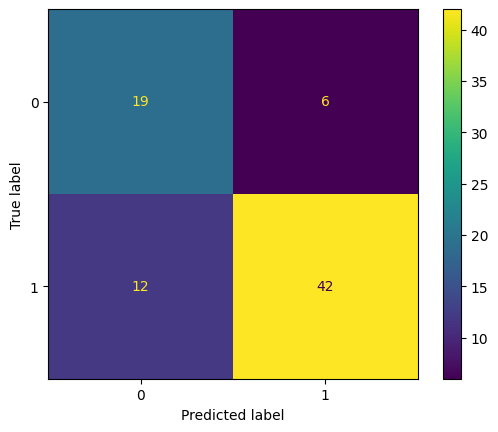

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test_le)

El método **RandomizedSearchCV** implementa una búsqueda aleatoria sobre los parámetros, donde cada valor se muestrea a partir de una distribución sobre los posibles valores de los parámetros.

La búsqueda aleatoria y la búsqueda exhaustiva en cuadrícula exploran exactamente el mismo espacio de parámetros. El resultado en la configuración de parámetros es bastante similar, mientras que el tiempo de ejecución de la búsqueda aleatoria es drásticamente inferior.

In [ ]:
import time
start_time = time.time()

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)

dist = {'penalty':['l1', 'l2'], 'C':loguniform(1e-3, 1e3)}
grid_search = RandomizedSearchCV(estimator=LogisticRegression(max_iter=10000, solver='saga'), param_distributions=dist, cv=5, scoring='f1')
grid_search.fit(X_train, y_train_le)
test_score = f1_score(y_test_le, grid_search.best_estimator_.predict(X_test))
print(f'El f1 score de validación es: {grid_search.best_score_:.3f} se obtiene con los siguientes hiperparámetos: {grid_search.best_params_}')
print(f'El f1 score de prueba es: {test_score:.3f}')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo transcurrido: {elapsed_time} segundos")

El f1 score de validación es: 0.795 se obtiene con los siguientes hiperparámetos: {'C': 0.011776352442665209, 'penalty': 'l1'}
El f1 score de prueba es: 0.824
Tiempo transcurrido: 5.869452714920044 segundos


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_le, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.76      0.68        25
           1       0.88      0.78      0.82        54

    accuracy                           0.77        79
   macro avg       0.74      0.77      0.75        79
weighted avg       0.79      0.77      0.78        79



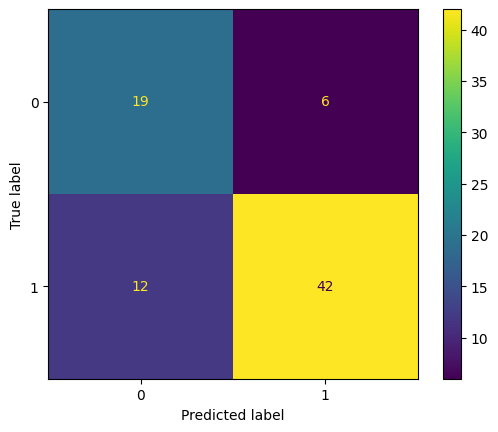

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test_le)

Scikit-learn también proporciona los estimadores **HalvingGridSearchCV** y **HalvingRandomSearchCV** que se pueden utilizar para buscar un espacio de parámetros utilizando sucesivas divisiones por mitades. La división sucesiva en dos es como un torneo entre combinaciones de parámetros candidatos. Es un proceso de selección iterativo en el que todos los candidatos (las combinaciones de parámetros) se evalúan con una pequeña cantidad de recursos en la primera iteración. Sólo algunos de estos candidatos se seleccionan para la siguiente iteración, a la que se asignarán más recursos.

Por ahora, estos métodos están en fase experimental, por lo que no se recomienda usarlos aún en proyectos importantes.

Por último, existen otras librerías que implementan métodos de sintonización muy robustos y eficientes basados en inferencia bayesiana. Si está interesado en estos métodos, puede consultar este enlace: https://github.com/ARM-software/mango.

# Acerca de las métricas

En Scikit Learn los scores que se muestran de las métricas *precision*, *recall* y *f1_score* son los que se han calculado con respecto a la clase que la librería tomo como **positiva**. Esto puede llevar a malas interpretaciones de los resultados. Veamos un ejemplo.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)

dist = {'penalty':['l1', 'l2'], 'C':loguniform(1e-3, 1e3)}
grid_search = RandomizedSearchCV(estimator=LogisticRegression(max_iter=10000, solver='saga'), param_distributions=dist, cv=5, scoring='f1')
grid_search.fit(X_train, y_train_le)
test_score = f1_score(y_test_le, grid_search.best_estimator_.predict(X_test))
print(f'El f1 score de validación es: {grid_search.best_score_:.3f} se obtiene con los siguientes hiperparámetos: {grid_search.best_params_}')
print(f'El f1 score de prueba es: {test_score:.3f}')

El f1 score de validación es: 0.787 se obtiene con los siguientes hiperparámetos: {'C': 0.1847780342425484, 'penalty': 'l1'}
El f1 score de prueba es: 0.824


Este resultado es el que se obtiene considerando como positiva la clase etiquetada '1'. A primera vista, este resultado es bueno.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_le, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.76      0.68        25
           1       0.88      0.78      0.82        54

    accuracy                           0.77        79
   macro avg       0.74      0.77      0.75        79
weighted avg       0.79      0.77      0.78        79



El reporte de clasificación da otra visión. Aquí se puede ver que para la clase 'O' el clasificador funciona peor que para la clase '1', siendo la clase '0' los vehículos producidos por fuera de Estados Unidos.

In [ ]:
le.classes_

array(['Other', 'USA'], dtype=object)

In [ ]:
test_score = f1_score(y_test_le, grid_search.best_estimator_.predict(X_test), pos_label=0)
print(f'El f1 score de la clase 0 en este modelo con los datos de prueba es: {test_score:.3f}')

El f1 score de la clase 0 en este modelo con los datos de prueba es: 0.679


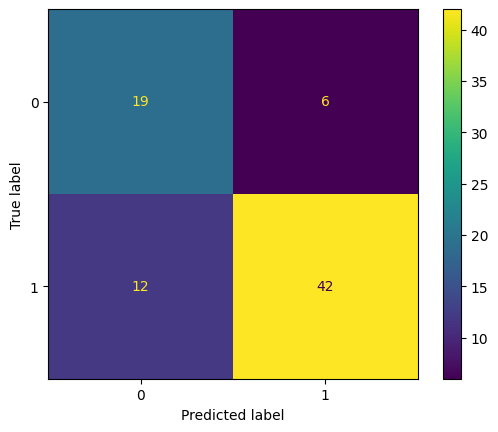

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test_le)

La matriz de confusión nos corrobora esto, que se equivoca mucho menos con la clase '1' que con la clase '0'. En este caso esto significa que predice mejor cuando un vehículo es de Estados Unidos que cuando no es de Estados Unidos.

¿Y si quiero sintonizar hiperparámetros tomando como clase positiva la otra?

Esto se puede hacer asi:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)

scorer=make_scorer(f1_score, pos_label=0)

dist = {'penalty':['l1', 'l2'], 'C':loguniform(1e-3, 1e3)}
grid_search = RandomizedSearchCV(estimator=LogisticRegression(max_iter=10000, solver='saga'), param_distributions=dist, cv=5, scoring=scorer)
grid_search.fit(X_train, y_train_le)
test_score = f1_score(y_test_le, grid_search.best_estimator_.predict(X_test), pos_label=0)
print(f'El f1 score de validación es: {grid_search.best_score_:.3f} se obtiene con los siguientes hiperparámetos: {grid_search.best_params_}')
print(f'El f1 score de prueba es: {test_score:.3f}')

El f1 score de validación es: 0.632 se obtiene con los siguientes hiperparámetos: {'C': 0.20906940205738492, 'penalty': 'l1'}
El f1 score de prueba es: 0.679


Pareciera que esto empeoró el modelo, pero no es así, los resultados son exactamente iguales a los del modelo anterior:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_le, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.76      0.68        25
           1       0.88      0.78      0.82        54

    accuracy                           0.77        79
   macro avg       0.74      0.77      0.75        79
weighted avg       0.79      0.77      0.78        79



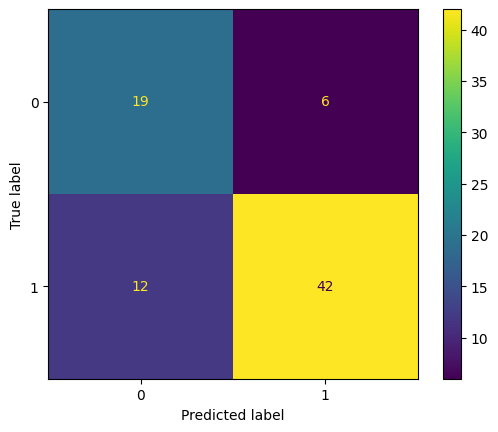

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test_le)

# Balanceo de clases

Lo habitual es querer un clasificador que se desempeñe bien con todas las clases, y no solo con una, asi que, sí este es el caso, deberíamos usar una métrica que tenga en cuenta a todas las clases.

Algunas métricas que hacen esto son **balanced_accuracy**, **f1 macro**, **f1 weighted**, y **matthews_corrcoef**.

Vamos a probar **f1 macro** y **f1 weighted**.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)

dist = {'penalty':['l1', 'l2'], 'C':loguniform(1e-3, 1e3)}
grid_search = RandomizedSearchCV(estimator=LogisticRegression(max_iter=10000, solver='saga'), param_distributions=dist, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train_le)
test_score = f1_score(y_test_le, grid_search.best_estimator_.predict(X_test), average='macro')
print(f'El f1 score de validación es: {grid_search.best_score_:.3f} se obtiene con los siguientes hiperparámetos: {grid_search.best_params_}')
print(f'El f1 score de prueba es: {test_score:.3f}')

El f1 score de validación es: 0.709 se obtiene con los siguientes hiperparámetos: {'C': 0.0024441860585198436, 'penalty': 'l2'}
El f1 score de prueba es: 0.751


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_le, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.76      0.68        25
           1       0.88      0.78      0.82        54

    accuracy                           0.77        79
   macro avg       0.74      0.77      0.75        79
weighted avg       0.79      0.77      0.78        79



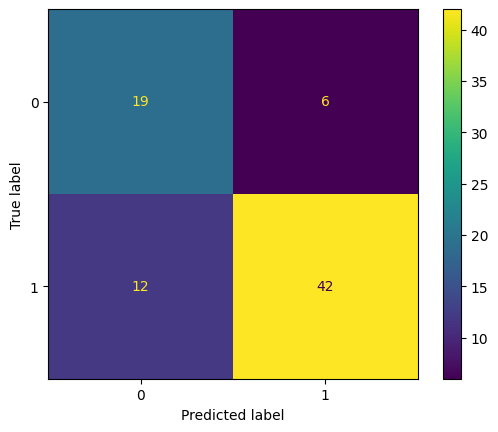

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test_le)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)

dist = {'penalty':['l1', 'l2'], 'C':loguniform(1e-3, 1e3)}
grid_search = RandomizedSearchCV(estimator=LogisticRegression(max_iter=10000, solver='saga'), param_distributions=dist, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train_le)
test_score = f1_score(y_test_le, grid_search.best_estimator_.predict(X_test), average='weighted')
print(f'El f1 score de validación es: {grid_search.best_score_:.3f} se obtiene con los siguientes hiperparámetos: {grid_search.best_params_}')
print(f'El f1 score de prueba es: {test_score:.3f}')

El f1 score de validación es: 0.727 se obtiene con los siguientes hiperparámetos: {'C': 0.27320192860463194, 'penalty': 'l1'}
El f1 score de prueba es: 0.778


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_le, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.76      0.68        25
           1       0.88      0.78      0.82        54

    accuracy                           0.77        79
   macro avg       0.74      0.77      0.75        79
weighted avg       0.79      0.77      0.78        79



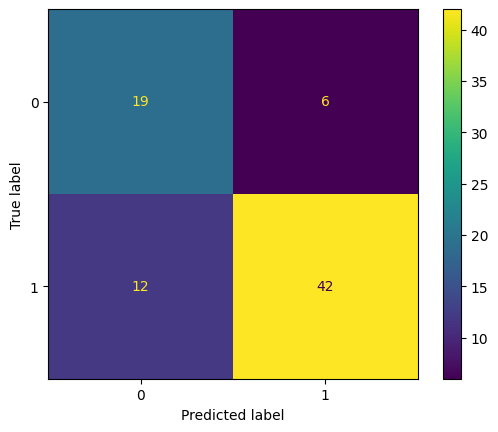

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test_le)

Cambiar la métrica en este caso no sirvió de nada. Pero se puede hacer algo más, que es intentar **balancear** los datos.

Balancear los datos significa en este contexto intentar que si hay 2 clases con mucha diferencia en el número de observaciones, la clase mayoritaria no oculte a la minoritaria.

Hay varios métodos de hacer balanceo de datos; el más simple es intentar darle más importancia a cada muestra de la clase minoritaria, que a cada muestra de la mayoritaria. En las modelos lineales esto se puede hacer configurando el parámetro **class_weight**.

Primero vamos a usar la opcion "balanced" que da un peso a cada clase inversamente proporcional al número de muestras que tiene.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)

dist = {'penalty':['l1', 'l2'], 'C':loguniform(1e-3, 1e3)}
grid_search = RandomizedSearchCV(estimator=LogisticRegression(max_iter=10000, solver='saga', class_weight='balanced'), param_distributions=dist, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train_le)
test_score = f1_score(y_test_le, grid_search.best_estimator_.predict(X_test), average='weighted')
print(f'El f1 score de validación es: {grid_search.best_score_:.3f} se obtiene con los siguientes hiperparámetos: {grid_search.best_params_}')
print(f'El f1 score de prueba es: {test_score:.3f}')

El f1 score de validación es: 0.751 se obtiene con los siguientes hiperparámetos: {'C': 0.0024991161590590914, 'penalty': 'l1'}
El f1 score de prueba es: 0.780


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_le, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.59      0.88      0.71        25
           1       0.93      0.72      0.81        54

    accuracy                           0.77        79
   macro avg       0.76      0.80      0.76        79
weighted avg       0.82      0.77      0.78        79



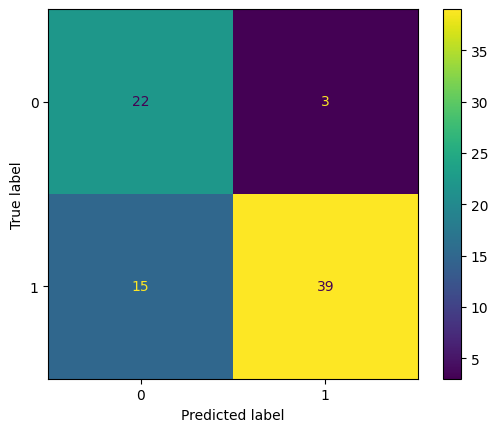

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test_le)

Vemos que esto si mejora el desempeño en la clase minoritaria mejora, aunque el desempeño en la mayoritaria cae un poco.

Se puede probar dando pesos personalizados a cada clase:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)

dist = {'penalty':['l1', 'l2'], 'C':loguniform(1e-3, 1e3)}
grid_search = RandomizedSearchCV(estimator=LogisticRegression(max_iter=10000, solver='saga', class_weight={0:2, 1:1}), param_distributions=dist, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train_le)
test_score = f1_score(y_test_le, grid_search.best_estimator_.predict(X_test), average='weighted')
print(f'El f1 score de validación es: {grid_search.best_score_:.3f} se obtiene con los siguientes hiperparámetos: {grid_search.best_params_}')
print(f'El f1 score de prueba es: {test_score:.3f}')

El f1 score de validación es: 0.765 se obtiene con los siguientes hiperparámetos: {'C': 0.008139700513700403, 'penalty': 'l2'}
El f1 score de prueba es: 0.768


En este caso le dimos a las muestras de la clase '0' el doble de importancia que a las muestras de la clae '1'.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_le, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.92      0.71        25
           1       0.95      0.69      0.80        54

    accuracy                           0.76        79
   macro avg       0.76      0.80      0.75        79
weighted avg       0.83      0.76      0.77        79



Como resultado, el modelo mejora su desempeño con la clase '0', pero lo empeora con la clase '1'.

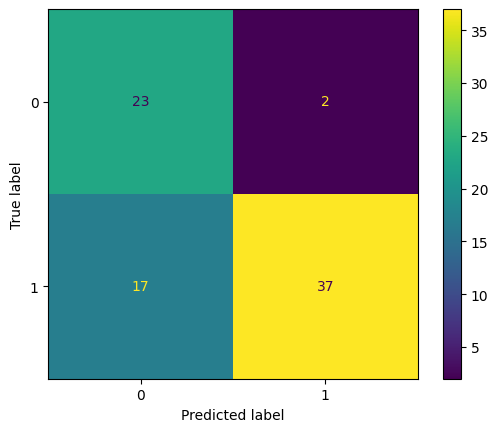

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test_le)